# Prepping data

In [1]:
import pandas as pd
import numpy as np
import swifter
from sklearn import metrics

pd.options.mode.chained_assignment = None

# Modeling

In [2]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def print_metrices(pred,true):
    print(confusion_matrix(true,pred))
    print(classification_report(true,pred,))
    print("Accuracy : ",accuracy_score(pred,true))
    print("Precison : ",precision_score(pred,true, average = 'weighted'))
    print("Recall : ",recall_score(pred,true,  average = 'weighted'))
    print("F1 : ",f1_score(pred,true,  average = 'weighted'))

In [3]:
import matplotlib.pyplot as plt
import itertools

# Applying confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
import pickle

title_model = pickle.load(open('./models/combined_title_pa_model.sav', 'rb'))
domain_model = pickle.load(open('./models/combined_domain_pa_model.sav', 'rb'))
content_model = pickle.load(open('./models/combined_content_pa_model.sav', 'rb'))

# Testing pipelines to retrieving relevant columns

In [5]:
kaggle_df = pd.read_csv('../Datasets/Combined_Dataset/combined_data.csv')
kaggle_df = kaggle_df.dropna()
kaggle_df = kaggle_df.replace(to_replace='None', value=np.nan).dropna()
kaggle_df.reset_index(drop=True, inplace=True)
kaggle_df = kaggle_df[kaggle_df.label != 'label']

kaggle_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7976 entries, 0 to 7976
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      7976 non-null   object
 1   title    7976 non-null   object
 2   content  7976 non-null   object
 3   label    7976 non-null   object
 4   domain   7976 non-null   object
dtypes: object(5)
memory usage: 373.9+ KB


In [6]:
kaggle_df.label.unique()

array(['reliable', 'fake'], dtype=object)

## Defining custom transformer for title, domain and content models

In [7]:
def get_domain(target_df):
    return target_df['domain']

def get_title(target_df):
    return target_df['title']

def get_content(target_df):
    return target_df['content']

get_domain(kaggle_df)

0                 bbc.com
1             reuters.com
2             nytimes.com
3             reuters.com
4                 cnn.com
              ...        
7972    beforeitsnews.com
7973    beforeitsnews.com
7974    beforeitsnews.com
7975          reuters.com
7976    beforeitsnews.com
Name: domain, Length: 7976, dtype: object

In [8]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
import re

ps = PorterStemmer()

def clean_content(series):
    for index, text in series.items(): 
        text = re.sub(r"http\S+", "", text)

        # Tokenize and Remove non alphanumeric characters
        tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
        tokens = tokenizer.tokenize(text)
        allalpha_tokens = [word for word in tokens if word.isalpha()]

        # Porter stemmer back to basic english words
        words = [ps.stem(word) for word in allalpha_tokens if not word in stopwords.words('english')]
        words = ' '.join(words)
        series[index] = words
    return series.replace(to_replace='None', value=np.nan).dropna()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pluto\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

domain_trans = FunctionTransformer(get_domain)
title_trans = FunctionTransformer(get_title)
content_trans = FunctionTransformer(get_content)
stemmer = FunctionTransformer(clean_content)

pipelined_domain_model = Pipeline([('domain_trans', domain_trans), ('domain_model', domain_model)])

pipelined_title_model = Pipeline([('title_trans', title_trans), ('title_model', title_model)])

pipelined_content_model = Pipeline([('content_trans', content_trans), ('content_model', content_model)])


In [10]:
testpred = pipelined_content_model.predict(kaggle_df)
metrics.accuracy_score(kaggle_df['label'], testpred)

0.9937311935807422

# Stacking PA classifiers together

In [10]:
from sklearn.ensemble import StackingClassifier
from sklearn import tree

stacked_model = StackingClassifier(
    estimators=[
        ('PA Domain', pipelined_domain_model),
        ('PA Title', pipelined_title_model),
        ('PA Content', pipelined_content_model)
    ],
    final_estimator = tree.DecisionTreeClassifier(max_depth=3, min_samples_leaf=5),
    verbose=1,
    n_jobs=-1
)

# Fitting Stacked Classifier

In [11]:
fakenewscorpus_df = pd.read_csv('../Datasets/Combined_Dataset/processed_content.csv')
fakenewscorpus_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 865520 entries, 0 to 865519
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   domain   865520 non-null  object
 1   label    865520 non-null  object
 2   url      865520 non-null  object
 3   content  865519 non-null  object
 4   title    865520 non-null  object
 5   author   865520 non-null  object
dtypes: object(6)
memory usage: 39.6+ MB


In [12]:
fakenewscorpus_df.dropna()
fakenewscorpus_df = fakenewscorpus_df.replace(to_replace='None', value=np.nan).dropna()
fakenewscorpus_df.reset_index(drop=True, inplace=True)
fakenewscorpus_df = fakenewscorpus_df[fakenewscorpus_df.label != 'label']
training_fakenewscorpus_df = fakenewscorpus_df.sample(frac=0.1)

training_fakenewscorpus_df = training_fakenewscorpus_df.reindex(columns=['url', 'title', 'content', 'label', 'domain'])
training_fakenewscorpus_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86548 entries, 408366 to 767559
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      86548 non-null  object
 1   title    86548 non-null  object
 2   content  86548 non-null  object
 3   label    86548 non-null  object
 4   domain   86548 non-null  object
dtypes: object(5)
memory usage: 4.0+ MB


In [13]:
training_fakenewscorpus_df.head()

,url,title,content,label,domain
408366,https://www.pravda.ru/tags/%D1%80%D0%BE%D1%81%...,Статьи и Новости по тэгу ростислав ищенко,как относиться к тому что кнр фактически выкуп...,fake,pravda.ru
92441,https://www.dailykos.com/stories/2017/04/10/16...,NRA ad attacked Jon Ossoff with a lie so blata...,republican get desper watch jon ossoff campaig...,reliable,dailykos.com
265227,https://www.dailykos.com/stories/2008/04/23/50...,"Okay, now what? a 50-state Electoral College a...",i know alreadi scream screen look hr button bu...,reliable,dailykos.com
716832,https://www.dailykos.com/stories/2009/07/24/75...,The kitchen sink brigade,when dow republican stop cite presid obama eco...,reliable,dailykos.com
587067,https://www.morningledger.com/dwayne-the-rock-...,Dwayne ‘The Rock’ Johnson Welcomes Baby Girl –...,hollywood actor semi profession wrestler dwayn...,fake,morningledger.com


In [14]:
large_data_df = pd.concat([training_fakenewscorpus_df, kaggle_df])
large_data_df

,url,title,content,label,domain
408366,https://www.pravda.ru/tags/%D1%80%D0%BE%D1%81%...,Статьи и Новости по тэгу ростислав ищенко,как относиться к тому что кнр фактически выкуп...,fake,pravda.ru
92441,https://www.dailykos.com/stories/2017/04/10/16...,NRA ad attacked Jon Ossoff with a lie so blata...,republican get desper watch jon ossoff campaig...,reliable,dailykos.com
265227,https://www.dailykos.com/stories/2008/04/23/50...,"Okay, now what? a 50-state Electoral College a...",i know alreadi scream screen look hr button bu...,reliable,dailykos.com
716832,https://www.dailykos.com/stories/2009/07/24/75...,The kitchen sink brigade,when dow republican stop cite presid obama eco...,reliable,dailykos.com
587067,https://www.morningledger.com/dwayne-the-rock-...,Dwayne ‘The Rock’ Johnson Welcomes Baby Girl –...,hollywood actor semi profession wrestler dwayn...,fake,morningledger.com
...,...,...,...,...,...
7972,http://beforeitsnews.com/u-s-politics/2017/10/...,CNN and Globalist Exposed - Steve Quayle and A...,"Vietnam Is in Great Danger, You Must Publish a...",fake,beforeitsnews.com
7973,http://beforeitsnews.com/sports/2017/09/trends...,Trends to Watch,Trends to Watch\n% of readers think this story...,fake,beforeitsnews.com
7974,http://beforeitsnews.com/u-s-politics/2017/10/...,Trump Jr. Is Soon To Give A 30-Minute Speech F...,Trump Jr. Is Soon To Give A 30-Minute Speech F...,fake,beforeitsnews.com
7975,https://www.reuters.com/article/us-china-pharm...,China to accept overseas trial data in bid to ...,SHANGHAI (Reuters) - China said it plans to ac...,reliable,reuters.com


In [15]:
large_data_df.label.unique()

array(['fake', 'reliable'], dtype=object)

In [16]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(large_data_df, test_size=0.3, random_state=42)

train_df

,url,title,content,label,domain
291268,https://www.dailykos.com/stories/2015/7/23/140...,xxx,ko media llc site content may use purpos witho...,reliable,dailykos.com
7706,http://beforeitsnews.com/business/2014/10/brea...,Breaking: Breathe Luxury auctioning off Dubai....,break breath luxuri auction dubai holiday jour...,fake,beforeitsnews.com
454012,http://dailycaller.com/2015/07/17/seven-islami...,"Obama: 7 Years, 7 Islamic Terror Attacks",on thursday muslim man kill four u marin attac...,reliable,dailycaller.com
4622,http://beforeitsnews.com/sports/2017/09/10-imp...,10 Important Stories From 09/29/17 Box Scores:...,10 Important Stories From 09/29/17 Box Scores:...,fake,beforeitsnews.com
350207,https://www.unz.com/gnxp/the-law-of-reversion-...,The law of reversion to type as cultural illusion,a comment as higher number genet characterist ...,fake,unz.com
...,...,...,...,...,...
843407,https://www.dailykos.com/stories/2012/07/03/11...,"BREAKING: Incredible mass rally in Aleppo, Syr...",the non mass movement far dead syria thousand ...,reliable,dailykos.com
303989,http://beforeitsnews.com/environment/2011/06/a...,Antibiotic use may have driven the development...,warn bewar blood event pleas stay away from co...,fake,beforeitsnews.com
248331,http://conservativepapers.com/news/2011/07/28/...,The Forgotten Man,what presid obama done against background dark...,fake,conservativepapers.com
818432,http://www.breitbart.com/tag/school-to-work/,school to work Articles,as republican stripe main media predict jeb bu...,reliable,breitbart.com


In [17]:
X_train = train_df.loc[:, train_df.columns != 'label']
Y_train = train_df['label']
X_test = test_df.loc[:, test_df.columns != 'label']
Y_test = test_df['label']

In [18]:
Y_train.unique()

array(['reliable', 'fake'], dtype=object)

In [19]:
stacked_model = stacked_model.fit(X_train, Y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 13.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
Exception ignored in: <function SeekableUnicodeStreamReader.__del__ at 0x000001B116C325E0>
Traceback (most recent call last):
  File "D:\Python\lib\site-packages\nltk\data.py", line 1160, in __del__
    self.close()
  File "D:\Python\lib\site-packages\nltk\data.py", line 1189, in close
    self.stream.close()
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
from sklearn import metrics

pred = stacked_model.predict(X_test)
score = metrics.accuracy_score(Y_test, pred)
print("Accuracy:   ", score)
cm = metrics.confusion_matrix(Y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'RELIABLE'])

In [ ]:
print_metrices(pred, Y_test)

# Testing data on remaining data from 2GB fakenewscorpus

In [ ]:
fakenewscorpus_df = fakenewscorpus_df.reindex(columns=['url', 'title', 'content', 'label', 'domain'])

fakenewscorpus_remaining_data = pd.concat([training_fakenewscorpus_df, fakenewscorpus_df]).drop_duplicates(keep=False)
fakenewscorpus_df_nolabel = fakenewscorpus_remaining_data.loc[:, fakenewscorpus_remaining_data.columns != 'label']
fakenewscorpus_df_labels = fakenewscorpus_remaining_data['label']

In [ ]:
fakenewscorpus_pred = stacked_model.predict(fakenewscorpus_df_nolabel)
fakenewscorpus_score = metrics.accuracy_score(fakenewscorpus_df_labels, fakenewscorpus_pred)
print("Accuracy:   ", fakenewscorpus_score)
fakenewscorpus_cm = metrics.confusion_matrix(fakenewscorpus_df_labels, fakenewscorpus_pred)

print_metrices(fakenewscorpus_pred, fakenewscorpus_df_labels)
plot_confusion_matrix(fakenewscorpus_cm, classes=['FAKE', 'RELIABLE'])

# Testing saved model

In [21]:
import pickle

filename = 'stacked_classifier.sav'
pickle.dump(stacked_model, open(filename, 'wb'))

print("Done saving model")

Done saving model


In [28]:
saved_stack_model = pickle.load(open('stacked_classifier.sav', 'rb'))

In [29]:
pred = saved_stack_model.predict(X_test)
score = metrics.accuracy_score(Y_test, pred)
print("Accuracy:   ", score)

D:\Python\lib\site-packages\sklearn\preprocessing\_function_transformer.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(X, **(kw_args if kw_args else {}))
Accuracy:    1.0


In [30]:
sampled_corpus_df = fakenewscorpus_df.sample(frac=0.2)

In [31]:
sampled_corpus_df_nolabel = sampled_corpus_df.loc[:, sampled_corpus_df.columns != 'label']
sampled_corpus_df_label = sampled_corpus_df['label']



In [34]:
sampled_corpus_df_label.unique()

array(['reliable', 'fake', 'label'], dtype=object)

D:\Python\lib\site-packages\sklearn\preprocessing\_function_transformer.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(X, **(kw_args if kw_args else {}))
Accuracy:    0.707378223495702
Confusion matrix, without normalization


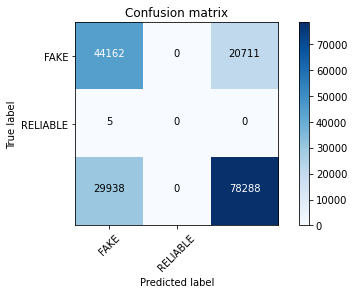

In [32]:
test_pred = saved_stack_model.predict(sampled_corpus_df_nolabel)
test_score = metrics.accuracy_score(sampled_corpus_df_label, test_pred)
print("Accuracy:   ", test_score)
test_cm = metrics.confusion_matrix(sampled_corpus_df_label, test_pred)
plot_confusion_matrix(test_cm, classes=['FAKE', 'RELIABLE'])